In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

/Users/kuoteng/.pyenv/versions/3.6.4/envs/NCKU-DSAI/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
DATA_SIZE = 60000
TRAIN_SIZE = 45000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + DIGITS + 1
chars = '0123456789+-* '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
EPOCH_SIZE = 1
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '*',
 2: '+',
 3: '-',
 4: '0',
 5: '1',
 6: '2',
 7: '3',
 8: '4',
 9: '5',
 10: '6',
 11: '7',
 12: '8',
 13: '9'}

# Data Generation

In [7]:
%time
questions = []
expected = []
seen = set()
print('Generating data...')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Generating data...


In [8]:
%time
while len(questions) < DATA_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    if len(questions) % 3 == 1:
        q = '{}-{}'.format(a, b)
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a - b)
    elif len(questions) % 3 == 2:
        q = '{}+{}'.format(a, b)
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a + b)
    else:
        q = '{}*{}'.format(a, b)
        query = q + ' ' * (MAXLEN - len(q))
        ans = str(a * b)
    if q in seen:
        continue
    seen.add(q)
    ans += ' ' * (MAXLEN - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs
Total addition questions: 60000


In [9]:
print(questions[:5], expected[:5])

['26*20  ', '29-45  ', '731+5  ', '85*62  ', '23-0   '] ['520    ', '-16    ', '736    ', '5270   ', '23     ']


# Processing

In [10]:
print('Vectorization... (to the one-hot encoding)')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), MAXLEN, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, MAXLEN)

Vectorization... (to the one-hot encoding)


In [11]:
indices = np.arange(len(y))
np.random.shuffle(indices)
print(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:TRAIN_SIZE]
train_y = y[:TRAIN_SIZE]
test_x = x[TRAIN_SIZE:]
test_y = y[TRAIN_SIZE:]

print('Training Data:')
print(train_x.shape)
print(train_y.shape)

split_at = len(train_x) - len(train_x) // 10
print('split_at', split_at)
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)


[37667 29385  3938 ... 25202 54239 44670]
Training Data:
(45000, 7, 14)
(45000, 7, 14)
split_at 40500
Training Data:
(40500, 7, 14)
(40500, 7, 14)
Validation Data:
(4500, 7, 14)
(4500, 7, 14)
Testing Data:
(15000, 7, 14)
(15000, 7, 14)


In [12]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False False False False False False False False
   False False  True]
  [False False False False False False False  True False False False
   False False False]
  [False False False False False False False False False  True False
   False False False]
  [False False  True False False False False False False False False
   False False False]
  [False False False False False False False False False False  True
   False False False]
  [False False False False False False  True False False False False
   False False False]
  [ True False False False False False False False False False False
   False False False]]

 [[False False False False False False False False False False False
    True False False]
  [False False False False False  True False False False False False
   False False False]
  [False False False False False False False  True False False False
   False False False]
  [False  True False False False False False False False False False
   False Fa

# Build Model

In [13]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(MAXLEN))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               73216     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 14)             1806      
_________________________________________________________________
activation_1 (Activation)    (None, 7, 14)             0         
Total params: 206,606
Trainable params: 206,606
Non-trainable params: 0
_________________________________________________________________


# Training

In [14]:
acc = []
val_acc = []
loss = []
val_loss = []
guesses = []
for loop in range(100):
    print()
    print('-' * 50)
    print('Train Loop Num:', loop)
    history = model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCH_SIZE,
                  validation_data=(x_val, y_val),
                  shuffle=True)
    acc += history.history['acc']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    val_loss += history.history['val_loss']
    right = 0
    preds = model.predict_classes(test_x, verbose=0)
    for i in range(len(preds)):
        q = ctable.decode(test_x[i])
        correct = ctable.decode(test_y[i])
        guess = ctable.decode(preds[i], calc_argmax=False)
        if correct == guess:
            right += 1
    print("MSG : Accuracy is {}".format(right / len(preds)))
    guesses.append(right / len(preds))


--------------------------------------------------
Train Loop Num: 0
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 12s 298us/step - loss: 1.3316 - acc: 0.5501 - val_loss: 1.1764 - val_acc: 0.5807
MSG : Accuracy is 0.0014666666666666667

--------------------------------------------------
Train Loop Num: 1
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 11s 284us/step - loss: 1.1357 - acc: 0.5895 - val_loss: 1.1151 - val_acc: 0.5926
MSG : Accuracy is 0.002

--------------------------------------------------
Train Loop Num: 2
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 11s 283us/step - loss: 1.0920 - acc: 0.6004 - val_loss: 1.0832 - val_acc: 0.6043
MSG : Accuracy is 0.0078

--------------------------------------------------
Train Loop Num: 3
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500

40500/40500 [==============================] - 12s 295us/step - loss: 0.3813 - acc: 0.8580 - val_loss: 0.4296 - val_acc: 0.8338
MSG : Accuracy is 0.37073333333333336

--------------------------------------------------
Train Loop Num: 29
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 12s 295us/step - loss: 0.3697 - acc: 0.8631 - val_loss: 0.4201 - val_acc: 0.8365
MSG : Accuracy is 0.38066666666666665

--------------------------------------------------
Train Loop Num: 30
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 12s 301us/step - loss: 0.3608 - acc: 0.8668 - val_loss: 0.4161 - val_acc: 0.8388
MSG : Accuracy is 0.39053333333333334

--------------------------------------------------
Train Loop Num: 31
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 13s 317us/step - loss: 0.3498 - acc: 0.8717 - val_loss: 0.4056 - 

40500/40500 [==============================] - 14s 355us/step - loss: 0.2062 - acc: 0.9286 - val_loss: 0.3392 - val_acc: 0.8771
MSG : Accuracy is 0.5068666666666667

--------------------------------------------------
Train Loop Num: 57
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 13s 331us/step - loss: 0.2017 - acc: 0.9297 - val_loss: 0.3167 - val_acc: 0.8849
MSG : Accuracy is 0.5165333333333333

--------------------------------------------------
Train Loop Num: 58
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 13s 331us/step - loss: 0.1978 - acc: 0.9313 - val_loss: 0.3148 - val_acc: 0.8858
MSG : Accuracy is 0.5241333333333333

--------------------------------------------------
Train Loop Num: 59
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 14s 343us/step - loss: 0.1957 - acc: 0.9320 - val_loss: 0.3201 - val

40500/40500 [==============================] - 13s 320us/step - loss: 0.1359 - acc: 0.9549 - val_loss: 0.3425 - val_acc: 0.8869
MSG : Accuracy is 0.5375333333333333

--------------------------------------------------
Train Loop Num: 85
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 12s 306us/step - loss: 0.1368 - acc: 0.9544 - val_loss: 0.3386 - val_acc: 0.8894
MSG : Accuracy is 0.5416

--------------------------------------------------
Train Loop Num: 86
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 12s 308us/step - loss: 0.1317 - acc: 0.9563 - val_loss: 0.3445 - val_acc: 0.8892
MSG : Accuracy is 0.539

--------------------------------------------------
Train Loop Num: 87
Train on 40500 samples, validate on 4500 samples
Epoch 1/1
40500/40500 [==============================] - 12s 304us/step - loss: 0.1257 - acc: 0.9591 - val_loss: 0.3407 - val_acc: 0.8894
MSG : Accura

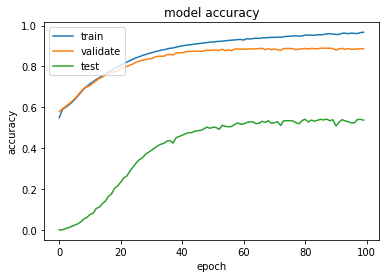

In [15]:
plt.plot(acc)
plt.plot(val_acc)
plt.plot(guesses)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate', 'test'], loc='upper left')
plt.savefig('./fig/multiply-jupyter-accuracy.png')
plt.show()

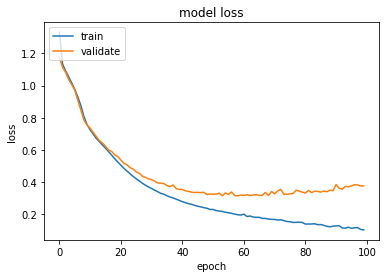

In [16]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig('./fig/multiply-jupyter-loss.png')
plt.show()

# Testing

In [17]:
print("MSG : Prediction")
print("-" * 50)
right = 0
preds = model.predict_classes(test_x, verbose=0)
for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        print(colors.ok + '☑' + colors.close, end=' ')
        right += 1
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(guess)
print("MSG : Accuracy is {}".format(right / len(preds)))

MSG : Prediction
--------------------------------------------------
Q 72+508  T 580     ☑ 580    
Q 81-51   T 30      ☒ 20     
Q 15*821  T 12315   ☒ 12015  
Q 62*98   T 6076    ☒ 6916   
Q 484-33  T 451     ☑ 451    
Q 370*1   T 370     ☑ 370    
Q 7+101   T 108     ☒ 118    
Q 64+81   T 145     ☑ 145    
Q 9-598   T -589    ☒ -581   
Q 208+144 T 352     ☑ 352    
Q 828+9   T 837     ☑ 837    
Q 602*62  T 37324   ☒ 37684  
Q 1+275   T 276     ☑ 276    
Q 4-94    T -90     ☑ -90    
Q 46+981  T 1027    ☒ 1037   
Q 97+84   T 181     ☑ 181    
Q 94+383  T 477     ☒ 487    
Q 20*9    T 180     ☑ 180    
Q 83*3    T 249     ☑ 249    
Q 1-334   T -333    ☑ -333   
Q 355-75  T 280     ☒ 270    
Q 3+947   T 950     ☒ 940    
Q 858*214 T 183612  ☒ 186512 
Q 28-954  T -926    ☑ -926   
Q 790*10  T 7900    ☒ 890    
Q 79*18   T 1422    ☒ 1412   
Q 2-632   T -630    ☑ -630   
Q 708+5   T 713     ☑ 713    
Q 4*209   T 836     ☒ 856    
Q 42*712  T 29904   ☒ 29324  
Q 80*584  T 46720   ☒ 47920  
Q 

Q 98*58   T 5684    ☒ 5624   
Q 9+536   T 545     ☑ 545    
Q 1-716   T -715    ☑ -715   
Q 903*404 T 364812  ☒ 360998 
Q 21*159  T 3339    ☒ 3779   
Q 160*62  T 9920    ☒ 10520  
Q 571-299 T 272     ☒ 262    
Q 43-15   T 28      ☑ 28     
Q 191+740 T 931     ☒ 943    
Q 68*833  T 56644   ☒ 56124  
Q 849+2   T 851     ☑ 851    
Q 21-777  T -756    ☒ -746   
Q 176*4   T 704     ☒ 794    
Q 5+628   T 633     ☑ 633    
Q 9-987   T -978    ☑ -978   
Q 615+2   T 617     ☑ 617    
Q 36*82   T 2952    ☒ 3032   
Q 4*461   T 1844    ☒ 1804   
Q 91-907  T -816    ☒ -806   
Q 247-4   T 243     ☑ 243    
Q 509+427 T 936     ☑ 936    
Q 451+5   T 456     ☑ 456    
Q 13-629  T -616    ☑ -616   
Q 6+182   T 188     ☒ 198    
Q 82+29   T 111     ☑ 111    
Q 375+35  T 410     ☒ 400    
Q 150-91  T 59      ☒ 51     
Q 517-90  T 427     ☑ 427    
Q 60*78   T 4680    ☒ 4620   
Q 6+404   T 410     ☑ 410    
Q 16+723  T 739     ☑ 739    
Q 92-17   T 75      ☑ 75     
Q 64+61   T 125     ☑ 125    
Q 765*6   

Q 283*85  T 24055   ☒ 24505  
Q 251+1   T 252     ☑ 252    
Q 5*785   T 3925    ☒ 3825   
Q 31-2    T 29      ☒ 39     
Q 747+695 T 1442    ☑ 1442   
Q 24*34   T 816     ☒ 736    
Q 3-235   T -232    ☑ -232   
Q 300*24  T 7200    ☒ 8400   
Q 307*1   T 307     ☑ 307    
Q 338*7   T 2366    ☒ 2356   
Q 3*93    T 279     ☑ 279    
Q 56-63   T -7      ☑ -7     
Q 26-987  T -961    ☑ -961   
Q 0+474   T 474     ☑ 474    
Q 3-688   T -685    ☑ -685   
Q 30+702  T 732     ☑ 732    
Q 6+909   T 915     ☑ 915    
Q 100*476 T 47600   ☒ 44604  
Q 33-15   T 18      ☑ 18     
Q 11+831  T 842     ☑ 842    
Q 58*46   T 2668    ☒ 2728   
Q 6*446   T 2676    ☒ 2636   
Q 740*2   T 1480    ☑ 1480   
Q 568+27  T 595     ☑ 595    
Q 287-69  T 218     ☒ 208    
Q 35-63   T -28     ☑ -28    
Q 738+8   T 746     ☑ 746    
Q 757-8   T 749     ☑ 749    
Q 109+153 T 262     ☒ 252    
Q 8-523   T -515    ☑ -515   
Q 76*88   T 6688    ☒ 6788   
Q 4*752   T 3008    ☒ 2048   
Q 299*27  T 8073    ☒ 8353   
Q 157+150 

Q 806*7   T 5642    ☒ 5792   
Q 442-744 T -302    ☒ -312   
Q 449+37  T 486     ☑ 486    
Q 256*14  T 3584    ☒ 3014   
Q 528*94  T 49632   ☒ 49472  
Q 180+13  T 193     ☑ 193    
Q 78-51   T 27      ☑ 27     
Q 5-183   T -178    ☑ -178   
Q 1*235   T 235     ☑ 235    
Q 251*460 T 115460  ☒ 1128600
Q 964-50  T 914     ☑ 914    
Q 17+920  T 937     ☒ 947    
Q 744+7   T 751     ☑ 751    
Q 316-36  T 280     ☒ 270    
Q 3*796   T 2388    ☑ 2388   
Q 6*558   T 3348    ☒ 3448   
Q 4*171   T 684     ☒ 724    
Q 113+2   T 115     ☑ 115    
Q 6+747   T 753     ☑ 753    
Q 8*578   T 4624    ☒ 4684   
Q 8+691   T 699     ☒ 791    
Q 0*695   T 0       ☑ 0      
Q 36*580  T 20880   ☒ 20480  
Q 30*50   T 1500    ☑ 1500   
Q 14-80   T -66     ☑ -66    
Q 108*89  T 9612    ☒ 9598   
Q 0-881   T -881    ☑ -881   
Q 244*8   T 1952    ☒ 1972   
Q 73+948  T 1021    ☑ 1021   
Q 98+27   T 125     ☑ 125    
Q 80-888  T -808    ☒ -708   
Q 283-463 T -180    ☒ -170   
Q 333-5   T 328     ☑ 328    
Q 766*253 

Q 4*44    T 176     ☑ 176    
Q 87-746  T -659    ☒ -669   
Q 991+91  T 1082    ☑ 1082   
Q 24+161  T 185     ☑ 185    
Q 30+783  T 813     ☒ 819    
Q 803-38  T 765     ☑ 765    
Q 52*55   T 2860    ☑ 2860   
Q 4-755   T -751    ☑ -751   
Q 0*23    T 0       ☑ 0      
Q 3-73    T -70     ☒ -60    
Q 85*71   T 6035    ☒ 5905   
Q 597-5   T 592     ☑ 592    
Q 186+43  T 229     ☑ 229    
Q 55+858  T 913     ☑ 913    
Q 7+122   T 129     ☒ 139    
Q 56*470  T 26320   ☒ 26880  
Q 2+625   T 627     ☑ 627    
Q 817+371 T 1188    ☒ 1189   
Q 293-61  T 232     ☒ 242    
Q 353+2   T 355     ☑ 355    
Q 46*80   T 3680    ☒ 3780   
Q 643*30  T 19290   ☒ 19292  
Q 3+26    T 29      ☒ 39     
Q 149+93  T 242     ☑ 242    
Q 392*293 T 114856  ☒ 114492 
Q 97-896  T -799    ☒ -899   
Q 702+2   T 704     ☑ 704    
Q 394*880 T 346720  ☒ 342240 
Q 73*794  T 57962   ☒ 58228  
Q 4*500   T 2000    ☑ 2000   
Q 128*9   T 1152    ☒ 1078   
Q 588-28  T 560     ☑ 560    
Q 68*43   T 2924    ☒ 2004   
Q 3-65    

Q 899+9   T 908     ☑ 908    
Q 70*396  T 27720   ☒ 26480  
Q 601*568 T 341368  ☒ 332558 
Q 87-720  T -633    ☑ -633   
Q 716-189 T 527     ☒ 539    
Q 29-33   T -4      ☑ -4     
Q 62-4    T 58      ☑ 58     
Q 11*17   T 187     ☒ 287    
Q 315+579 T 894     ☒ 982    
Q 998-469 T 529     ☒ 531    
Q 676-4   T 672     ☑ 672    
Q 93+75   T 168     ☑ 168    
Q 16*20   T 320     ☒ 360    
Q 449*29  T 13021   ☒ 13421  
Q 769+7   T 776     ☑ 776    
Q 775-3   T 772     ☑ 772    
Q 81+76   T 157     ☑ 157    
Q 9+19    T 28      ☑ 28     
Q 92*74   T 6808    ☒ 6762   
Q 23-88   T -65     ☑ -65    
Q 93-48   T 45      ☑ 45     
Q 9*847   T 7623    ☒ 7603   
Q 8+558   T 566     ☑ 566    
Q 1+956   T 957     ☑ 957    
Q 25+74   T 99      ☑ 99     
Q 94+73   T 167     ☑ 167    
Q 5*37    T 185     ☑ 185    
Q 8+555   T 563     ☑ 563    
Q 82-48   T 34      ☑ 34     
Q 182*64  T 11648   ☒ 12148  
Q 9+196   T 205     ☑ 205    
Q 8+62    T 70      ☑ 70     
Q 8*38    T 304     ☑ 304    
Q 866+5   

Q 37+75   T 112     ☑ 112    
Q 16*5    T 80      ☒ 70     
Q 50-560  T -510    ☒ -500   
Q 6-870   T -864    ☑ -864   
Q 79*97   T 7663    ☒ 7623   
Q 737+88  T 825     ☒ 835    
Q 73+529  T 602     ☒ 502    
Q 94*914  T 85916   ☒ 84736  
Q 36-73   T -37     ☑ -37    
Q 98-57   T 41      ☒ 31     
Q 14+745  T 759     ☒ 749    
Q 5*683   T 3415    ☑ 3415   
Q 731-1   T 730     ☒ 720    
Q 98-827  T -729    ☒ -739   
Q 852-67  T 785     ☑ 785    
Q 521-569 T -48     ☒ -68    
Q 46*33   T 1518    ☒ 1558   
Q 247-207 T 40      ☒ 12     
Q 8-596   T -588    ☑ -588   
Q 344*9   T 3096    ☒ 3116   
Q 436-501 T -65     ☒ -67    
Q 478-693 T -215    ☑ -215   
Q 5*77    T 385     ☑ 385    
Q 695-919 T -224    ☒ -124   
Q 893-27  T 866     ☑ 866    
Q 81-903  T -822    ☑ -822   
Q 88+136  T 224     ☑ 224    
Q 83+361  T 444     ☒ 434    
Q 231*791 T 182721  ☒ 193981 
Q 497+2   T 499     ☑ 499    
Q 608-56  T 552     ☑ 552    
Q 96-0    T 96      ☑ 96     
Q 14*156  T 2184    ☒ 2864   
Q 0-386   

Q 217-197 T 20      ☒ 48     
Q 29+595  T 624     ☑ 624    
Q 42-534  T -492    ☑ -492   
Q 603-7   T 596     ☑ 596    
Q 550-812 T -262    ☑ -262   
Q 59+0    T 59      ☑ 59     
Q 218+80  T 298     ☑ 298    
Q 934*30  T 28020   ☒ 28060  
Q 614-4   T 610     ☑ 610    
Q 89-80   T 9       ☑ 9      
Q 140+304 T 444     ☑ 444    
Q 3+160   T 163     ☑ 163    
Q 21+46   T 67      ☑ 67     
Q 9*157   T 1413    ☒ 1313   
Q 437+72  T 509     ☑ 509    
Q 8-15    T -7      ☑ -7     
Q 97*11   T 1067    ☑ 1067   
Q 734*699 T 513066  ☒ 595116 
Q 7*951   T 6657    ☒ 6697   
Q 505-49  T 456     ☑ 456    
Q 592*61  T 36112   ☒ 36932  
Q 879+9   T 888     ☑ 888    
Q 469-85  T 384     ☒ 394    
Q 547+48  T 595     ☑ 595    
Q 257-97  T 160     ☑ 160    
Q 613*806 T 494078  ☒ 491438 
Q 2+693   T 695     ☑ 695    
Q 184*128 T 23552   ☒ 31132  
Q 7+328   T 335     ☒ 325    
Q 527+952 T 1479    ☒ 1489   
Q 854*5   T 4270    ☒ 4910   
Q 89+85   T 174     ☑ 174    
Q 523+45  T 568     ☑ 568    
Q 56*55   

Q 39-9    T 30      ☒ 20     
Q 21-7    T 14      ☑ 14     
Q 201+845 T 1046    ☑ 1046   
Q 3*936   T 2808    ☒ 2798   
Q 44*2    T 88      ☒ 82     
Q 9-221   T -212    ☒ -202   
Q 829+41  T 870     ☒ 860    
Q 514*33  T 16962   ☒ 16732  
Q 12-664  T -652    ☑ -652   
Q 955*16  T 15280   ☒ 14840  
Q 686*407 T 279202  ☒ 270822 
Q 16+5    T 21      ☑ 21     
Q 130+13  T 143     ☒ 133    
Q 907+412 T 1319    ☑ 1319   
Q 34+70   T 104     ☑ 104    
Q 973+337 T 1310    ☒ 1200   
Q 965*968 T 934120  ☒ 948710 
Q 480-342 T 138     ☒ 238    
Q 408+12  T 420     ☑ 420    
Q 377-628 T -251    ☒ -259   
Q 973*161 T 156653  ☒ 158378 
Q 518+7   T 525     ☑ 525    
Q 535+888 T 1423    ☑ 1423   
Q 58+81   T 139     ☒ 149    
Q 230-255 T -25     ☒ -555   
Q 478+566 T 1044    ☑ 1044   
Q 603*72  T 43416   ☒ 44156  
Q 1+805   T 806     ☑ 806    
Q 8*617   T 4936    ☒ 4906   
Q 55-65   T -10     ☑ -10    
Q 937-2   T 935     ☑ 935    
Q 742*3   T 2226    ☒ 2286   
Q 8+786   T 794     ☑ 794    
Q 470+8   

Q 46*17   T 782     ☒ 792    
Q 7+510   T 517     ☑ 517    
Q 1*950   T 950     ☑ 950    
Q 9-151   T -142    ☑ -142   
Q 0-737   T -737    ☑ -737   
Q 80+3    T 83      ☑ 83     
Q 19-132  T -113    ☒ -123   
Q 560+0   T 560     ☑ 560    
Q 34+29   T 63      ☑ 63     
Q 515*0   T 0       ☑ 0      
Q 948*3   T 2844    ☒ 2894   
Q 6+31    T 37      ☒ 35     
Q 601+6   T 607     ☒ 605    
Q 11+927  T 938     ☑ 938    
Q 9-453   T -444    ☑ -444   
Q 7-497   T -490    ☑ -490   
Q 46-404  T -358    ☒ -368   
Q 67*298  T 19966   ☒ 20046  
Q 456*273 T 124488  ☒ 124558 
Q 14*48   T 672     ☒ 712    
Q 288-36  T 252     ☒ 242    
Q 3*73    T 219     ☒ 239    
Q 377*5   T 1885    ☒ 1925   
Q 290*74  T 21460   ☒ 20440  
Q 72+83   T 155     ☑ 155    
Q 59+867  T 926     ☒ 916    
Q 317*12  T 3804    ☒ 4304   
Q 797+15  T 812     ☑ 812    
Q 80+49   T 129     ☑ 129    
Q 2*662   T 1324    ☒ 1304   
Q 559-305 T 254     ☒ 236    
Q 121-555 T -434    ☒ -426   
Q 79*778  T 61462   ☒ 69812  
Q 16*129  

Q 4*582   T 2328    ☒ 2368   
Q 38-388  T -350    ☒ -340   
Q 946-84  T 862     ☒ 850    
Q 528+66  T 594     ☑ 594    
Q 99+27   T 126     ☑ 126    
Q 61-64   T -3      ☒ -      
Q 145*218 T 31610   ☒ 38094  
Q 3-306   T -303    ☑ -303   
Q 35-70   T -35     ☑ -35    
Q 22-739  T -717    ☑ -717   
Q 9+40    T 49      ☑ 49     
Q 26*24   T 624     ☒ 634    
Q 4+458   T 462     ☑ 462    
Q 44+952  T 996     ☒ 9006   
Q 78+899  T 977     ☒ 987    
Q 603-73  T 530     ☑ 530    
Q 9*214   T 1926    ☒ 1936   
Q 49*878  T 43022   ☒ 42802  
Q 21*8    T 168     ☒ 178    
Q 17+627  T 644     ☒ 634    
Q 719+62  T 781     ☒ 789    
Q 386*0   T 0       ☑ 0      
Q 564*566 T 319224  ☒ 310074 
Q 2*640   T 1280    ☑ 1280   
Q 869-650 T 219     ☒ 129    
Q 81-859  T -778    ☒ -788   
Q 84+10   T 94      ☑ 94     
Q 17-768  T -751    ☑ -751   
Q 701*133 T 93233   ☒ 97913  
Q 448-315 T 133     ☑ 133    
Q 1*960   T 960     ☑ 960    
Q 236+8   T 244     ☑ 244    
Q 502*711 T 356922  ☒ 367552 
Q 659+0   

Q 56-715  T -659    ☑ -659   
Q 151+60  T 211     ☑ 211    
Q 7+61    T 68      ☑ 68     
Q 49+0    T 49      ☑ 49     
Q 13*234  T 3042    ☒ 3762   
Q 46-220  T -174    ☒ -184   
Q 47*917  T 43099   ☒ 44199  
Q 2-725   T -723    ☑ -723   
Q 573+790 T 1363    ☑ 1363   
Q 166*683 T 113378  ☒ 110898 
Q 406*6   T 2436    ☒ 2506   
Q 690*15  T 10350   ☒ 1070   
Q 489-82  T 407     ☑ 407    
Q 782+644 T 1426    ☒ 1416   
Q 79+440  T 519     ☒ 529    
Q 1+12    T 13      ☑ 13     
Q 288-383 T -95     ☑ -95    
Q 56+53   T 109     ☑ 109    
Q 94-162  T -68     ☑ -68    
Q 437-345 T 92      ☑ 92     
Q 76-891  T -815    ☒ -825   
Q 94*4    T 376     ☑ 376    
Q 60*21   T 1260    ☑ 1260   
Q 40*121  T 4840    ☒ 4540   
Q 55-475  T -420    ☑ -420   
Q 80+479  T 559     ☒ 569    
Q 714*198 T 141372  ☒ 142212 
Q 19-538  T -519    ☒ -529   
Q 7*493   T 3451    ☒ 3471   
Q 66*79   T 5214    ☒ 5094   
Q 522+4   T 526     ☑ 526    
Q 16+440  T 456     ☒ 466    
Q 664-9   T 655     ☑ 655    
Q 133+193 

Q 76*271  T 20596   ☒ 20776  
Q 34-913  T -879    ☒ -889   
Q 59+53   T 112     ☑ 112    
Q 36-975  T -939    ☑ -939   
Q 679*65  T 44135   ☒ 44095  
Q 2*36    T 72      ☑ 72     
Q 11*2    T 22      ☑ 22     
Q 995*1   T 995     ☑ 995    
Q 0*2     T 0       ☑ 0      
Q 3+903   T 906     ☑ 906    
Q 7*853   T 5971    ☒ 5991   
Q 70*751  T 52570   ☒ 51110  
Q 711*9   T 6399    ☒ 6499   
Q 2+624   T 626     ☑ 626    
Q 855+0   T 855     ☑ 855    
Q 729*46  T 33534   ☒ 33134  
Q 62+313  T 375     ☑ 375    
Q 7+882   T 889     ☒ 899    
Q 621+26  T 647     ☑ 647    
Q 401*785 T 314785  ☒ 314385 
Q 226-492 T -266    ☒ -246   
Q 899*262 T 235538  ☒ 238778 
Q 586-5   T 581     ☑ 581    
Q 570-49  T 521     ☒ 501    
Q 541*49  T 26509   ☒ 26389  
Q 447-8   T 439     ☑ 439    
Q 76+80   T 156     ☑ 156    
Q 17*750  T 12750   ☒ 12070  
Q 168+3   T 171     ☑ 171    
Q 0-793   T -793    ☑ -793   
Q 26+6    T 32      ☑ 32     
Q 9+437   T 446     ☑ 446    
Q 61+94   T 155     ☑ 155    
Q 233-7   

Q 84+85   T 169     ☑ 169    
Q 762-965 T -203    ☒ -111   
Q 861*23  T 19803   ☒ 29063  
Q 26*78   T 2028    ☒ 2148   
Q 84*846  T 71064   ☒ 71336  
Q 490*499 T 244510  ☒ 233210 
Q 107+978 T 1085    ☒ 1073   
Q 0*527   T 0       ☑ 0      
Q 923+312 T 1235    ☒ 1215   
Q 815+31  T 846     ☑ 846    
Q 9*152   T 1368    ☒ 1388   
Q 80+698  T 778     ☑ 778    
Q 211-129 T 82      ☒ 92     
Q 770-165 T 605     ☒ 595    
Q 3+87    T 90      ☑ 90     
Q 473*8   T 3784    ☒ 3704   
Q 449*39  T 17511   ☒ 18121  
Q 190*152 T 28880   ☒ 26220  
Q 254-171 T 83      ☒ 53     
Q 619*9   T 5571    ☒ 5391   
Q 73*79   T 5767    ☒ 5717   
Q 288+1   T 289     ☑ 289    
Q 6-261   T -255    ☑ -255   
Q 9+44    T 53      ☑ 53     
Q 99*727  T 71973   ☒ 70383  
Q 662*86  T 56932   ☒ 58492  
Q 927*118 T 109386  ☒ 101294 
Q 158+229 T 387     ☒ 487    
Q 578-48  T 530     ☒ 520    
Q 605-0   T 605     ☑ 605    
Q 84*916  T 76944   ☒ 77336  
Q 57+1    T 58      ☑ 58     
Q 438-7   T 431     ☑ 431    
Q 59*91   

Q 173+220 T 393     ☒ 303    
Q 87-626  T -539    ☑ -539   
Q 49-26   T 23      ☑ 23     
Q 65-8    T 57      ☑ 57     
Q 62-86   T -24     ☑ -24    
Q 632-25  T 607     ☑ 607    
Q 1+217   T 218     ☑ 218    
Q 551+70  T 621     ☑ 621    
Q 977-8   T 969     ☑ 969    
Q 81+629  T 710     ☒ 702    
Q 269+309 T 578     ☒ 548    
Q 934*9   T 8406    ☒ 8416   
Q 296-987 T -691    ☒ -681   
Q 693*61  T 42273   ☒ 43273  
Q 363-70  T 293     ☒ 283    
Q 95-987  T -892    ☑ -892   
Q 875-662 T 213     ☒ 203    
Q 46-62   T -16     ☑ -16    
Q 785*77  T 60445   ☒ 69785  
Q 974-24  T 950     ☒ 952    
Q 527+7   T 534     ☑ 534    
Q 996-68  T 928     ☒ 920    
Q 595+228 T 823     ☒ 803    
Q 5*40    T 200     ☑ 200    
Q 44*4    T 176     ☑ 176    
Q 14*7    T 98      ☒ 18     
Q 9+634   T 643     ☑ 643    
Q 39+18   T 57      ☑ 57     
Q 94-1    T 93      ☑ 93     
Q 3-962   T -959    ☒ -969   
Q 542-90  T 452     ☑ 452    
Q 944+722 T 1666    ☒ 1776   
Q 0*496   T 0       ☑ 0      
Q 840+3   

Q 4-22    T -18     ☑ -18    
Q 29-5    T 24      ☑ 24     
Q 28*63   T 1764    ☒ 1874   
Q 181-4   T 177     ☑ 177    
Q 34*1    T 34      ☑ 34     
Q 9-247   T -238    ☑ -238   
Q 650-4   T 646     ☑ 646    
Q 6+622   T 628     ☑ 628    
Q 96+98   T 194     ☑ 194    
Q 31-76   T -45     ☒ -47    
Q 551-0   T 551     ☑ 551    
Q 2+7     T 9       ☒ 1      
Q 37*22   T 814     ☑ 814    
Q 9-839   T -830    ☒ -820   
Q 242-4   T 238     ☑ 238    
Q 9-419   T -410    ☒ -510   
Q 89-22   T 67      ☑ 67     
Q 25-295  T -270    ☒ -260   
Q 4*480   T 1920    ☒ 1980   
Q 4-616   T -612    ☑ -612   
Q 121-66  T 55      ☑ 55     
Q 48+74   T 122     ☑ 122    
Q 54+801  T 855     ☒ 845    
Q 41*626  T 25666   ☒ 26216  
Q 8-409   T -401    ☑ -401   
Q 938-20  T 918     ☑ 918    
Q 24-108  T -84     ☒ -64    
Q 29*56   T 1624    ☒ 1444   
Q 27-915  T -888    ☒ -898   
Q 1+914   T 915     ☑ 915    
Q 2-268   T -266    ☑ -266   
Q 262+2   T 264     ☑ 264    
Q 861+36  T 897     ☑ 897    
Q 36+7    

Q 7*936   T 6552    ☒ 6522   
Q 139-9   T 130     ☒ 120    
Q 468+94  T 562     ☑ 562    
Q 406-7   T 399     ☒ 499    
Q 4-54    T -50     ☒ -40    
Q 49+728  T 777     ☑ 777    
Q 876+58  T 934     ☒ 944    
Q 976+2   T 978     ☑ 978    
Q 799-7   T 792     ☑ 792    
Q 687-154 T 533     ☑ 533    
Q 45+452  T 497     ☒ 597    
Q 2*801   T 1602    ☑ 1602   
Q 7-97    T -90     ☑ -90    
Q 5*407   T 2035    ☑ 2035   
Q 94+808  T 902     ☑ 902    
Q 99*665  T 65835   ☒ 66005  
Q 90*51   T 4590    ☒ 4550   
Q 640-772 T -132    ☑ -132   
Q 9-906   T -897    ☒ -997   
Q 8+453   T 461     ☑ 461    
Q 268+1   T 269     ☑ 269    
Q 12-8    T 4       ☑ 4      
Q 54-18   T 36      ☑ 36     
Q 264+85  T 349     ☒ 359    
Q 638+8   T 646     ☑ 646    
Q 532*39  T 20748   ☒ 21148  
Q 235+224 T 459     ☒ 479    
Q 4+407   T 411     ☑ 411    
Q 949*2   T 1898    ☒ 1998   
Q 394+18  T 412     ☑ 412    
Q 976+27  T 1003    ☒ 9033   
Q 5-838   T -833    ☑ -833   
Q 3*30    T 90      ☑ 90     
Q 4*92    

Q 4*316   T 1264    ☒ 1294   
Q 411*59  T 24249   ☒ 23329  
Q 6-905   T -899    ☑ -899   
Q 40+32   T 72      ☑ 72     
Q 28-63   T -35     ☑ -35    
Q 31+1    T 32      ☑ 32     
Q 873-15  T 858     ☑ 858    
Q 35*26   T 910     ☒ 930    
Q 3+292   T 295     ☑ 295    
Q 40*71   T 2840    ☑ 2840   
Q 71+78   T 149     ☑ 149    
Q 212*23  T 4876    ☒ 5396   
Q 441-759 T -318    ☒ -308   
Q 22*627  T 13794   ☒ 14084  
Q 83*517  T 42911   ☒ 43391  
Q 681*6   T 4086    ☒ 4066   
Q 941*4   T 3764    ☒ 3704   
Q 9-708   T -699    ☑ -699   
Q 427*5   T 2135    ☒ 2195   
Q 1*195   T 195     ☑ 195    
Q 885-2   T 883     ☑ 883    
Q 707-410 T 297     ☒ 207    
Q 1*996   T 996     ☑ 996    
Q 88-579  T -491    ☑ -491   
Q 93+22   T 115     ☑ 115    
Q 388+502 T 890     ☒ 880    
Q 7*443   T 3101    ☒ 3241   
Q 966-89  T 877     ☑ 877    
Q 194*14  T 2716    ☒ 2356   
Q 98-8    T 90      ☑ 90     
Q 226*440 T 99440   ☒ 101760 
Q 45*34   T 1530    ☑ 1530   
Q 32+40   T 72      ☑ 72     
Q 88+75   

Q 476+813 T 1289    ☑ 1289   
Q 45-8    T 37      ☑ 37     
Q 857+568 T 1425    ☑ 1425   
Q 50-89   T -39     ☑ -39    
Q 85-983  T -898    ☑ -898   
Q 941*7   T 6587    ☒ 6627   
Q 795+0   T 795     ☑ 795    
Q 5+299   T 304     ☑ 304    
Q 42*460  T 19320   ☒ 19880  
Q 89+809  T 898     ☑ 898    
Q 679+641 T 1320    ☑ 1320   
Q 242-464 T -222    ☒ -232   
Q 477*64  T 30528   ☒ 30238  
Q 78*51   T 3978    ☒ 3048   
Q 7*258   T 1806    ☒ 1866   
Q 5+165   T 170     ☒ 160    
Q 5-698   T -693    ☑ -693   
Q 467-73  T 394     ☑ 394    
Q 2+584   T 586     ☑ 586    
Q 36-657  T -621    ☒ -629   
Q 776*0   T 0       ☑ 0      
Q 820+33  T 853     ☑ 853    
Q 690+2   T 692     ☑ 692    
Q 466*91  T 42406   ☒ 43836  
Q 569*60  T 34140   ☒ 35940  
Q 995+669 T 1664    ☒ 1563   
Q 285-24  T 261     ☑ 261    
Q 867*5   T 4335    ☒ 4395   
Q 72+4    T 76      ☑ 76     
Q 868-841 T 27      ☒ 37     
Q 60-37   T 23      ☑ 23     
Q 222-20  T 202     ☒ 212    
Q 96-17   T 79      ☒ 71     
Q 682-91  

Q 75-86   T -11     ☑ -11    
Q 8*389   T 3112    ☒ 3182   
Q 82+779  T 861     ☑ 861    
Q 7+683   T 690     ☑ 690    
Q 82*358  T 29356   ☒ 29226  
Q 2*79    T 158     ☑ 158    
Q 0-85    T -85     ☑ -85    
Q 29-27   T 2       ☒ 1      
Q 714*39  T 27846   ☒ 27856  
Q 198-43  T 155     ☑ 155    
Q 7*962   T 6734    ☒ 6794   
Q 50-45   T 5       ☑ 5      
Q 702-815 T -113    ☒ -133   
Q 685*8   T 5480    ☒ 5380   
Q 9*1     T 9       ☑ 9      
Q 286-2   T 284     ☑ 284    
Q 391-48  T 343     ☒ 353    
Q 4*23    T 92      ☑ 92     
Q 83-5    T 78      ☑ 78     
Q 376-26  T 350     ☑ 350    
Q 8+85    T 93      ☑ 93     
Q 58-958  T -900    ☒ -890   
Q 607+40  T 647     ☑ 647    
Q 862*721 T 621502  ☒ 600012 
Q 55+7    T 62      ☑ 62     
Q 183-9   T 174     ☑ 174    
Q 966+259 T 1225    ☒ 1235   
Q 52+39   T 91      ☑ 91     
Q 75*509  T 38175   ☒ 38455  
Q 575*742 T 426650  ☒ 436600 
Q 22+99   T 121     ☑ 121    
Q 8+238   T 246     ☑ 246    
Q 95+4    T 99      ☑ 99     
Q 12+704  

Q 745+460 T 1205    ☒ 1203   
Q 58*64   T 3712    ☒ 3752   
Q 532*83  T 44156   ☒ 44436  
Q 8*43    T 344     ☑ 344    
Q 890+38  T 928     ☒ 938    
Q 655-16  T 639     ☑ 639    
Q 452+10  T 462     ☑ 462    
Q 65*51   T 3315    ☒ 3245   
Q 52+21   T 73      ☑ 73     
Q 74*4    T 296     ☑ 296    
Q 37-86   T -49     ☑ -49    
Q 554-20  T 534     ☑ 534    
Q 4*99    T 396     ☑ 396    
Q 42*44   T 1848    ☒ 1968   
Q 22-7    T 15      ☑ 15     
Q 466*917 T 427322  ☒ 411072 
Q 8*952   T 7616    ☒ 7676   
Q 588*868 T 510384  ☒ 592284 
Q 22*51   T 1122    ☒ 1002   
Q 79+11   T 90      ☑ 90     
Q 350+45  T 395     ☑ 395    
Q 569*946 T 538274  ☒ 539454 
Q 0*120   T 0       ☑ 0      
Q 84+2    T 86      ☑ 86     
Q 12-72   T -60     ☑ -60    
Q 554+702 T 1256    ☒ 1266   
Q 78+0    T 78      ☑ 78     
Q 58*90   T 5220    ☒ 5320   
Q 77*60   T 4620    ☒ 4680   
Q 60+7    T 67      ☑ 67     
Q 3+85    T 88      ☑ 88     
Q 310-35  T 275     ☑ 275    
Q 14-78   T -64     ☑ -64    
Q 17+85   

Q 5+438   T 443     ☑ 443    
Q 2-230   T -228    ☑ -228   
Q 67-990  T -923    ☑ -923   
Q 65*8    T 520     ☒ 500    
Q 91+4    T 95      ☑ 95     
Q 47+12   T 59      ☑ 59     
Q 279+9   T 288     ☑ 288    
Q 839-53  T 786     ☑ 786    
Q 9-14    T -5      ☑ -5     
Q 456+554 T 1010    ☒ 1002   
Q 764-928 T -164    ☒ -154   
Q 938+85  T 1023    ☑ 1023   
Q 440+3   T 443     ☑ 443    
Q 851-47  T 804     ☑ 804    
Q 646-79  T 567     ☑ 567    
Q 3*40    T 120     ☑ 120    
Q 130*74  T 9620    ☒ 9720   
Q 230+153 T 383     ☑ 383    
Q 1*200   T 200     ☑ 200    
Q 859*13  T 11167   ☒ 11787  
Q 162-1   T 161     ☑ 161    
Q 25+31   T 56      ☑ 56     
Q 42-862  T -820    ☑ -820   
Q 7+90    T 97      ☑ 97     
Q 2-283   T -281    ☑ -281   
Q 856+88  T 944     ☑ 944    
Q 115+3   T 118     ☑ 118    
Q 1*15    T 15      ☑ 15     
Q 78*677  T 52806   ☒ 53226  
Q 558*712 T 397296  ☒ 404936 
Q 98+790  T 888     ☒ 898    
Q 66-437  T -371    ☑ -371   
Q 428-60  T 368     ☒ 378    
Q 380*10  

Q 7*68    T 476     ☒ 466    
Q 21*294  T 6174    ☒ 5484   
Q 596*74  T 44104   ☒ 44874  
Q 8*977   T 7816    ☒ 7796   
Q 905+675 T 1580    ☒ 1670   
Q 680*14  T 9520    ☒ 9020   
Q 714*68  T 48552   ☒ 47472  
Q 291+5   T 296     ☑ 296    
Q 40*90   T 3600    ☑ 3600   
Q 725+48  T 773     ☑ 773    
Q 245+4   T 249     ☑ 249    
Q 89*28   T 2492    ☒ 2552   
Q 333+9   T 342     ☑ 342    
Q 54-517  T -463    ☑ -463   
Q 6+995   T 1001    ☑ 1001   
Q 7+359   T 366     ☑ 366    
Q 4-46    T -42     ☑ -42    
Q 668-752 T -84     ☒ -8     
Q 922-965 T -43     ☒ -52    
Q 845+714 T 1559    ☑ 1559   
Q 338+48  T 386     ☑ 386    
Q 65*596  T 38740   ☒ 39280  
Q 199+603 T 802     ☒ 890    
Q 60*5    T 300     ☑ 300    
Q 354+3   T 357     ☑ 357    
Q 3-106   T -103    ☑ -103   
Q 19-98   T -79     ☑ -79    
Q 51+362  T 413     ☑ 413    
Q 783+43  T 826     ☑ 826    
Q 1*59    T 59      ☑ 59     
Q 601*1   T 601     ☑ 601    
Q 56+989  T 1045    ☒ 1445   
Q 9-497   T -488    ☑ -488   
Q 316*95  

Q 79-15   T 64      ☑ 64     
Q 25*285  T 7125    ☒ 7225   
Q 57*64   T 3648    ☒ 3618   
Q 724*270 T 195480  ☒ 198280 
Q 34-48   T -14     ☑ -14    
Q 73-731  T -658    ☑ -658   
Q 55-0    T 55      ☑ 55     
Q 6+612   T 618     ☑ 618    
Q 301*496 T 149296  ☒ 165876 
Q 30+604  T 634     ☑ 634    
Q 733+7   T 740     ☑ 740    
Q 463*76  T 35188   ☒ 34348  
Q 962+766 T 1728    ☒ 1618   
Q 87*192  T 16704   ☒ 16824  
Q 80-923  T -843    ☑ -843   
Q 724*0   T 0       ☑ 0      
Q 413-9   T 404     ☒ 304    
Q 1-542   T -541    ☑ -541   
Q 5*81    T 405     ☑ 405    
Q 999+9   T 1008    ☒ 1088   
Q 52-0    T 52      ☑ 52     
Q 359-976 T -617    ☒ -607   
Q 994+59  T 1053    ☒ 1042   
Q 284+26  T 310     ☑ 310    
Q 646-87  T 559     ☒ 569    
Q 64+9    T 73      ☑ 73     
Q 640-3   T 637     ☑ 637    
Q 5-383   T -378    ☑ -378   
Q 20-66   T -46     ☑ -46    
Q 986+27  T 1013    ☒ 1023   
Q 475*758 T 360050  ☒ 362650 
Q 852-675 T 177     ☒ 18     
Q 90+98   T 188     ☒ 118    
Q 934*47  

Q 35-987  T -952    ☑ -952   
Q 568+7   T 575     ☑ 575    
Q 53-787  T -734    ☑ -734   
Q 381*3   T 1143    ☑ 1143   
Q 300-0   T 300     ☑ 300    
Q 83-562  T -479    ☒ -489   
Q 40*604  T 24160   ☒ 25640  
Q 38+35   T 73      ☑ 73     
Q 70*55   T 3850    ☑ 3850   
Q 755-93  T 662     ☑ 662    
Q 9+542   T 551     ☑ 551    
Q 24*620  T 14880   ☒ 15680  
Q 125+348 T 473     ☑ 473    
Q 47-734  T -687    ☑ -687   
Q 69*98   T 6762    ☒ 6722   
Q 56*1    T 56      ☑ 56     
Q 205+402 T 607     ☒ 613    
Q 0*607   T 0       ☑ 0      
Q 38-31   T 7       ☒ 1      
Q 189*39  T 7371    ☒ 7921   
Q 4*43    T 172     ☑ 172    
Q 561-504 T 57      ☒ 15     
Q 94+46   T 140     ☑ 140    
Q 3+42    T 45      ☑ 45     
Q 84*98   T 8232    ☒ 8252   
Q 622-9   T 613     ☑ 613    
Q 1*831   T 831     ☑ 831    
Q 927*4   T 3708    ☒ 3798   
Q 578+5   T 583     ☑ 583    
Q 68*620  T 42160   ☒ 42240  
Q 571*9   T 5139    ☒ 5959   
Q 75*59   T 4425    ☒ 4305   
Q 847*6   T 5082    ☑ 5082   
Q 603+91  

Q 579*898 T 519942  ☒ 579232 
Q 2+703   T 705     ☑ 705    
Q 548-286 T 262     ☒ 272    
Q 9*16    T 144     ☑ 144    
Q 248*94  T 23312   ☒ 22572  
Q 8-619   T -611    ☑ -611   
Q 90+569  T 659     ☑ 659    
Q 62+56   T 118     ☑ 118    
Q 40+3    T 43      ☑ 43     
Q 5+23    T 28      ☑ 28     
Q 345-16  T 329     ☒ 339    
Q 50+135  T 185     ☒ 285    
Q 399*243 T 96957   ☒ 901435 
Q 90-65   T 25      ☑ 25     
Q 446+8   T 454     ☑ 454    
Q 54+417  T 471     ☑ 471    
Q 95-900  T -805    ☒ -815   
Q 937-234 T 703     ☒ 601    
Q 459-507 T -48     ☒ -68    
Q 88+67   T 155     ☑ 155    
Q 80+40   T 120     ☑ 120    
Q 56*5    T 280     ☑ 280    
Q 11+213  T 224     ☑ 224    
Q 206+7   T 213     ☑ 213    
Q 2-445   T -443    ☑ -443   
Q 32-386  T -354    ☒ -364   
Q 774*226 T 174924  ☒ 168824 
Q 6-747   T -741    ☑ -741   
Q 285*5   T 1425    ☑ 1425   
Q 122*9   T 1098    ☒ 1168   
Q 36-499  T -463    ☒ -453   
Q 562+991 T 1553    ☒ 1543   
Q 876-351 T 525     ☑ 525    
Q 89-735  

Q 439+121 T 560     ☑ 560    
Q 8*466   T 3728    ☒ 3808   
Q 7+536   T 543     ☑ 543    
Q 78-996  T -918    ☒ -928   
Q 251+195 T 446     ☒ 546    
Q 460*97  T 44620   ☒ 42820  
Q 389*569 T 221341  ☒ 224431 
Q 182*752 T 136864  ☒ 131144 
Q 939+287 T 1226    ☒ 1116   
Q 638+594 T 1232    ☑ 1232   
Q 71+164  T 235     ☑ 235    
Q 66+430  T 496     ☒ 596    
Q 77*28   T 2156    ☒ 2116   
Q 7+918   T 925     ☑ 925    
Q 501-18  T 483     ☑ 483    
Q 456-7   T 449     ☑ 449    
Q 538-680 T -142    ☒ -132   
Q 575-736 T -161    ☒ -171   
Q 733+3   T 736     ☑ 736    
Q 8*920   T 7360    ☒ 7480   
Q 1+74    T 75      ☑ 75     
Q 329*1   T 329     ☑ 329    
Q 3+569   T 572     ☑ 572    
Q 1-512   T -511    ☑ -511   
Q 399+466 T 865     ☒ 855    
Q 37-851  T -814    ☑ -814   
Q 17-30   T -13     ☑ -13    
Q 797+46  T 843     ☑ 843    
Q 72*632  T 45504   ☒ 44244  
Q 4-583   T -579    ☑ -579   
Q 89*766  T 68174   ☒ 67954  
Q 879-983 T -104    ☒ -10    
Q 29-39   T -10     ☑ -10    
Q 0*111   

Q 607-742 T -135    ☒ -265   
Q 582-9   T 573     ☑ 573    
Q 17+92   T 109     ☑ 109    
Q 3*20    T 60      ☑ 60     
Q 884-2   T 882     ☑ 882    
Q 947*64  T 60608   ☒ 60978  
Q 2*696   T 1392    ☑ 1392   
Q 49+358  T 407     ☑ 407    
Q 78-3    T 75      ☑ 75     
Q 868-91  T 777     ☒ 767    
Q 247-823 T -576    ☑ -576   
Q 311+72  T 383     ☑ 383    
Q 7+770   T 777     ☑ 777    
Q 2-77    T -75     ☑ -75    
Q 6+483   T 489     ☒ 481    
Q 95+772  T 867     ☑ 867    
Q 722-375 T 347     ☑ 347    
Q 3+609   T 612     ☑ 612    
Q 14-5    T 9       ☑ 9      
Q 16*3    T 48      ☒ 58     
Q 474-31  T 443     ☒ 433    
Q 2*983   T 1966    ☒ 1946   
Q 69*452  T 31188   ☒ 32288  
Q 54*489  T 26406   ☒ 25886  
Q 39+210  T 249     ☒ 239    
Q 697-2   T 695     ☑ 695    
Q 658*718 T 472444  ☒ 465364 
Q 886*626 T 554636  ☒ 550136 
Q 517-43  T 474     ☑ 474    
Q 561*73  T 40953   ☒ 40233  
Q 667-7   T 660     ☑ 660    
Q 100-967 T -867    ☒ -857   
Q 7*18    T 126     ☑ 126    
Q 800*8   

Q 287+0   T 287     ☑ 287    
Q 57*444  T 25308   ☒ 25938  
Q 980-78  T 902     ☒ 912    
Q 4-162   T -158    ☒ -152   
Q 17*9    T 153     ☑ 153    
Q 257+8   T 265     ☑ 265    
Q 52-8    T 44      ☑ 44     
Q 60-434  T -374    ☑ -374   
Q 4*165   T 660     ☒ 680    
Q 750-3   T 747     ☑ 747    
Q 347-0   T 347     ☑ 347    
Q 965+2   T 967     ☑ 967    
Q 4-173   T -169    ☑ -169   
Q 84*357  T 29988   ☒ 29168  
Q 64*62   T 3968    ☒ 4968   
Q 9*728   T 6552    ☒ 6432   
Q 7+362   T 369     ☑ 369    
Q 301*19  T 5719    ☒ 5819   
Q 825-104 T 721     ☒ 711    
Q 284*0   T 0       ☑ 0      
Q 226*9   T 2034    ☒ 2114   
Q 1+789   T 790     ☑ 790    
Q 865-34  T 831     ☑ 831    
Q 55-331  T -276    ☑ -276   
Q 7+792   T 799     ☒ 801    
Q 250-4   T 246     ☑ 246    
Q 41*7    T 287     ☑ 287    
Q 245-327 T -82     ☒ -8     
Q 8*806   T 6448    ☒ 6548   
Q 172-4   T 168     ☒ 178    
Q 740*76  T 56240   ☒ 56280  
Q 748*0   T 0       ☑ 0      
Q 128-726 T -598    ☒ -684   
Q 3-930   

Q 868*204 T 177072  ☒ 177732 
Q 23*4    T 92      ☒ 88     
Q 398+9   T 407     ☑ 407    
Q 38*206  T 7828    ☒ 8046   
Q 82*80   T 6560    ☒ 6480   
Q 8*395   T 3160    ☑ 3160   
Q 977+624 T 1601    ☒ 1591   
Q 583-431 T 152     ☒ 222    
Q 670-793 T -123    ☑ -123   
Q 120-404 T -284    ☒ -286   
Q 32*16   T 512     ☒ 572    
Q 507*721 T 365547  ☒ 371957 
Q 791-13  T 778     ☒ 776    
Q 858-65  T 793     ☑ 793    
Q 11-575  T -564    ☑ -564   
Q 8-141   T -133    ☑ -133   
Q 78+321  T 399     ☑ 399    
Q 693*9   T 6237    ☑ 6237   
Q 559-489 T 70      ☒ 100    
Q 872+733 T 1605    ☑ 1605   
Q 590-6   T 584     ☑ 584    
Q 19+36   T 55      ☑ 55     
Q 864*92  T 79488   ☒ 80488  
Q 6+67    T 73      ☑ 73     
Q 4-259   T -255    ☑ -255   
Q 61+969  T 1030    ☑ 1030   
Q 42+39   T 81      ☑ 81     
Q 2*99    T 198     ☑ 198    
Q 9+313   T 322     ☑ 322    
Q 4+248   T 252     ☑ 252    
Q 3*543   T 1629    ☑ 1629   
Q 948*53  T 50244   ☒ 50354  
Q 185+58  T 243     ☑ 243    
Q 95-661  

Q 31-7    T 24      ☑ 24     
Q 842+95  T 937     ☑ 937    
Q 37-25   T 12      ☑ 12     
Q 0-590   T -590    ☒ -580   
Q 7-406   T -399    ☒ -499   
Q 385*7   T 2695    ☒ 2715   
Q 50+86   T 136     ☑ 136    
Q 6+97    T 103     ☑ 103    
Q 579+829 T 1408    ☒ 1428   
Q 573-4   T 569     ☑ 569    
Q 375-653 T -278    ☒ -288   
Q 66-598  T -532    ☑ -532   
Q 793+783 T 1576    ☒ 1586   
Q 667-171 T 496     ☒ 596    
Q 961-99  T 862     ☒ 752    
Q 4*64    T 256     ☒ 266    
Q 39-200  T -161    ☒ -121   
Q 670-1   T 669     ☒ 661    
Q 709-7   T 702     ☑ 702    
Q 82-66   T 16      ☑ 16     
Q 3*531   T 1593    ☒ 1613   
Q 465*49  T 22785   ☒ 22715  
Q 244*497 T 121268  ☒ 126398 
Q 745*1   T 745     ☑ 745    
Q 966+0   T 966     ☑ 966    
Q 630+843 T 1473    ☑ 1473   
Q 707*1   T 707     ☑ 707    
Q 90-413  T -323    ☑ -323   
Q 379+0   T 379     ☑ 379    
Q 515*507 T 261105  ☒ 269945 
Q 980*6   T 5880    ☑ 5880   
Q 80+23   T 103     ☑ 103    
Q 878+861 T 1739    ☒ 1749   
Q 18*2    

Q 408+988 T 1396    ☑ 1396   
Q 873-5   T 868     ☑ 868    
Q 89+686  T 775     ☑ 775    
Q 490*0   T 0       ☑ 0      
Q 912-8   T 904     ☑ 904    
Q 87+800  T 887     ☑ 887    
Q 107+10  T 117     ☒ 107    
Q 303*646 T 195738  ☒ 206868 
Q 394+1   T 395     ☑ 395    
Q 36*838  T 30168   ☒ 31448  
Q 87*97   T 8439    ☑ 8439   
Q 85*90   T 7650    ☑ 7650   
Q 3+413   T 416     ☑ 416    
Q 151*763 T 115213  ☒ 110333 
Q 548+124 T 672     ☑ 672    
Q 29-20   T 9       ☒ 1      
Q 600+2   T 602     ☑ 602    
Q 310+75  T 385     ☑ 385    
Q 854-77  T 777     ☑ 777    
Q 18*5    T 90      ☑ 90     
Q 70*141  T 9870    ☒ 9230   
Q 634*28  T 17752   ☒ 17132  
Q 90+94   T 184     ☑ 184    
Q 7+175   T 182     ☑ 182    
Q 264-4   T 260     ☑ 260    
Q 5-811   T -806    ☑ -806   
Q 256*6   T 1536    ☒ 1516   
Q 288*236 T 67968   ☒ 62418  
Q 169+9   T 178     ☒ 188    
Q 695+2   T 697     ☑ 697    
Q 749*7   T 5243    ☑ 5243   
Q 84*8    T 672     ☑ 672    
Q 0-698   T -698    ☑ -698   
Q 45+122  

Q 10*795  T 7950    ☑ 7950   
Q 479+51  T 530     ☑ 530    
Q 45-3    T 42      ☑ 42     
Q 119*140 T 16660   ☒ 20220  
Q 33+664  T 697     ☒ 607    
Q 387-519 T -132    ☒ -232   
Q 0-98    T -98     ☑ -98    
Q 514+0   T 514     ☑ 514    
Q 4+105   T 109     ☑ 109    
Q 50*182  T 9100    ☒ 9400   
Q 820*34  T 27880   ☒ 27380  
Q 3+328   T 331     ☑ 331    
Q 543*2   T 1086    ☑ 1086   
Q 753*384 T 289152  ☒ 271152 
Q 9*514   T 4626    ☑ 4626   
Q 447-3   T 444     ☑ 444    
Q 29+63   T 92      ☒ 98     
Q 330-1   T 329     ☒ 339    
Q 81+50   T 131     ☑ 131    
Q 915-6   T 909     ☑ 909    
Q 109*42  T 4578    ☒ 4298   
Q 49*182  T 8918    ☒ 9198   
Q 23*798  T 18354   ☒ 19164  
Q 172-27  T 145     ☑ 145    
Q 452-7   T 445     ☑ 445    
Q 589-6   T 583     ☑ 583    
Q 808-7   T 801     ☑ 801    
Q 864*73  T 63072   ☒ 64222  
Q 88*64   T 5632    ☒ 5572   
Q 713+37  T 750     ☑ 750    
Q 352+65  T 417     ☑ 417    
Q 4-225   T -221    ☑ -221   
Q 75*282  T 21150   ☒ 21950  
Q 137-7   

Q 92*511  T 47012   ☒ 46452  
Q 65+2    T 67      ☑ 67     
Q 321+319 T 640     ☑ 640    
Q 857-731 T 126     ☒ 116    
Q 21+722  T 743     ☒ 753    
Q 2-41    T -39     ☑ -39    
Q 740+435 T 1175    ☒ 1165   
Q 48-27   T 21      ☒ 29     
Q 1-145   T -144    ☑ -144   
Q 97-30   T 67      ☑ 67     
Q 2+627   T 629     ☑ 629    
Q 0-3     T -3      ☒ -1     
Q 27+476  T 503     ☑ 503    
Q 82-396  T -314    ☑ -314   
Q 41*63   T 2583    ☒ 2623   
Q 454-4   T 450     ☑ 450    
Q 2+533   T 535     ☑ 535    
Q 0-537   T -537    ☑ -537   
Q 33+30   T 63      ☑ 63     
Q 81-45   T 36      ☑ 36     
Q 91*91   T 8281    ☒ 8371   
Q 867*4   T 3468    ☒ 3408   
Q 0-0     T 0       ☒ -0     
Q 252*50  T 12600   ☑ 12600  
Q 691+301 T 992     ☒ 1022   
Q 82+844  T 926     ☑ 926    
Q 20-393  T -373    ☒ -383   
Q 124*913 T 113212  ☒ 116122 
Q 529-780 T -251    ☑ -251   
Q 560+3   T 563     ☑ 563    
Q 703+3   T 706     ☑ 706    
Q 2-272   T -270    ☑ -270   
Q 124-262 T -138    ☑ -138   
Q 57+3    

Q 640*20  T 12800   ☒ 12400  
Q 7+676   T 683     ☑ 683    
Q 665-497 T 168     ☒ 158    
Q 29-2    T 27      ☑ 27     
Q 922+6   T 928     ☒ 938    
Q 82*9    T 738     ☑ 738    
Q 600-0   T 600     ☒ 500    
Q 9*617   T 5553    ☒ 5533   
Q 92*42   T 3864    ☒ 3884   
Q 671+6   T 677     ☑ 677    
Q 2-796   T -794    ☑ -794   
Q 59+13   T 72      ☑ 72     
Q 906*460 T 416760  ☒ 408740 
Q 988+2   T 990     ☑ 990    
Q 19*57   T 1083    ☒ 1023   
Q 7*621   T 4347    ☒ 4267   
Q 471*98  T 46158   ☒ 47848  
Q 35+99   T 134     ☑ 134    
Q 446*1   T 446     ☑ 446    
Q 14*0    T 0       ☑ 0      
Q 0-26    T -26     ☑ -26    
Q 755+97  T 852     ☑ 852    
Q 9*628   T 5652    ☒ 5772   
Q 8-52    T -44     ☑ -44    
Q 51+352  T 403     ☒ 413    
Q 661*77  T 50897   ☒ 50277  
Q 921-8   T 913     ☑ 913    
Q 39+256  T 295     ☑ 295    
Q 377*50  T 18850   ☒ 18150  
Q 371-919 T -548    ☒ -538   
Q 62-81   T -19     ☒ -29    
Q 90-438  T -348    ☑ -348   
Q 639+9   T 648     ☑ 648    
Q 43+386  

Q 4*673   T 2692    ☒ 2732   
Q 4-497   T -493    ☑ -493   
Q 43-351  T -308    ☑ -308   
Q 914+70  T 984     ☑ 984    
Q 456+55  T 511     ☒ 411    
Q 40*901  T 36040   ☒ 36200  
Q 975+689 T 1664    ☑ 1664   
Q 45*861  T 38745   ☒ 40095  
Q 969+6   T 975     ☑ 975    
Q 702+608 T 1310    ☑ 1310   
Q 21-468  T -447    ☑ -447   
Q 359-4   T 355     ☑ 355    
Q 16*65   T 1040    ☒ 1030   
Q 384*809 T 310656  ☒ 300136 
Q 9-914   T -905    ☒ -907   
Q 88+63   T 151     ☑ 151    
Q 78*49   T 3822    ☑ 3822   
Q 60+328  T 388     ☒ 398    
Q 373+82  T 455     ☑ 455    
Q 406*713 T 289478  ☒ 288748 
Q 418*8   T 3344    ☒ 3244   
Q 48-858  T -810    ☑ -810   
Q 276*436 T 120336  ☒ 126376 
Q 23*16   T 368     ☒ 418    
Q 970-581 T 389     ☒ 381    
Q 433-16  T 417     ☑ 417    
Q 13+136  T 149     ☒ 141    
Q 65-73   T -8      ☑ -8     
Q 87-95   T -8      ☑ -8     
Q 505-425 T 80      ☒ 1      
Q 180+51  T 231     ☑ 231    
Q 7+74    T 81      ☑ 81     
Q 367-1   T 366     ☑ 366    
Q 35-21   

Q 684*7   T 4788    ☒ 4698   
Q 7-831   T -824    ☑ -824   
Q 6*32    T 192     ☑ 192    
Q 35+46   T 81      ☑ 81     
Q 835*4   T 3340    ☒ 3440   
Q 629-576 T 53      ☒ 63     
Q 47*717  T 33699   ☒ 34419  
Q 250*166 T 41500   ☒ 45700  
Q 0*663   T 0       ☑ 0      
Q 33*213  T 7029    ☒ 6299   
Q 475+873 T 1348    ☒ 1358   
Q 642-734 T -92     ☒ -88    
Q 125+940 T 1065    ☒ 1085   
Q 25*545  T 13625   ☒ 14675  
Q 83-3    T 80      ☑ 80     
Q 917+77  T 994     ☒ 984    
Q 730+1   T 731     ☑ 731    
Q 7+902   T 909     ☑ 909    
Q 40*923  T 36920   ☒ 37680  
Q 43*2    T 86      ☑ 86     
Q 3+89    T 92      ☑ 92     
Q 76*4    T 304     ☑ 304    
Q 647*73  T 47231   ☒ 46831  
Q 490+0   T 490     ☑ 490    
Q 957-612 T 345     ☒ 235    
Q 46-35   T 11      ☒ 1      
Q 84*20   T 1680    ☑ 1680   
Q 276-983 T -707    ☒ -607   
Q 684-63  T 621     ☑ 621    
Q 107-232 T -125    ☒ -165   
Q 3+62    T 65      ☑ 65     
Q 99-347  T -248    ☒ -258   
Q 84*6    T 504     ☒ 494    
Q 35*84   

Q 7+214   T 221     ☑ 221    
Q 406-52  T 354     ☒ 344    
Q 80*496  T 39680   ☒ 39520  
Q 68+646  T 714     ☑ 714    
Q 24-898  T -874    ☑ -874   
Q 76-28   T 48      ☑ 48     
Q 47*476  T 22372   ☒ 22522  
Q 5-413   T -408    ☑ -408   
Q 116-54  T 62      ☒ 58     
Q 6+55    T 61      ☑ 61     
Q 506+177 T 683     ☒ 771    
Q 506-619 T -113    ☒ -193   
Q 881-21  T 860     ☑ 860    
Q 66+35   T 101     ☑ 101    
Q 160+8   T 168     ☑ 168    
Q 493-8   T 485     ☑ 485    
Q 541+3   T 544     ☑ 544    
Q 8+663   T 671     ☑ 671    
Q 195*673 T 131235  ☒ 122855 
Q 4-855   T -851    ☑ -851   
Q 782*647 T 505954  ☒ 480214 
Q 33*88   T 2904    ☒ 2964   
Q 2-417   T -415    ☑ -415   
Q 759+2   T 761     ☑ 761    
Q 170-532 T -362    ☒ -372   
Q 238+36  T 274     ☑ 274    
Q 624+240 T 864     ☑ 864    
Q 521+81  T 602     ☒ 612    
Q 299-457 T -158    ☑ -158   
Q 977*60  T 58620   ☒ 67980  
Q 507+819 T 1326    ☒ 1386   
Q 12-69   T -57     ☑ -57    
Q 21+325  T 346     ☑ 346    
Q 514-24  

Q 22-975  T -953    ☑ -953   
Q 480+671 T 1151    ☑ 1151   
Q 2+10    T 12      ☑ 12     
Q 78-2    T 76      ☑ 76     
Q 47*30   T 1410    ☑ 1410   
Q 64+340  T 404     ☒ 394    
Q 38*34   T 1292    ☒ 1312   
Q 90-793  T -703    ☒ -793   
Q 719*3   T 2157    ☒ 2177   
Q 99-0    T 99      ☑ 99     
Q 676*655 T 442780  ☒ 453430 
Q 657-10  T 647     ☑ 647    
Q 128+0   T 128     ☑ 128    
Q 5*94    T 470     ☒ 460    
Q 291*3   T 873     ☒ 833    
Q 99+34   T 133     ☒ 123    
Q 29*748  T 21692   ☒ 21442  
Q 957+15  T 972     ☑ 972    
Q 32*48   T 1536    ☒ 1596   
Q 95-36   T 59      ☑ 59     
Q 85+14   T 99      ☑ 99     
Q 319+0   T 319     ☑ 319    
Q 740+0   T 740     ☑ 740    
Q 870-38  T 832     ☒ 822    
Q 81-5    T 76      ☑ 76     
Q 6+331   T 337     ☑ 337    
Q 90*448  T 40320   ☒ 39720  
Q 47-23   T 24      ☑ 24     
Q 20-3    T 17      ☑ 17     
Q 264-938 T -674    ☑ -674   
Q 4+858   T 862     ☑ 862    
Q 624+91  T 715     ☑ 715    
Q 7*345   T 2415    ☒ 2595   
Q 93-603  

Q 654*3   T 1962    ☒ 1902   
Q 356+3   T 359     ☑ 359    
Q 8-121   T -113    ☑ -113   
Q 25*272  T 6800    ☒ 7100   
Q 28-87   T -59     ☑ -59    
Q 1-822   T -821    ☑ -821   
Q 5*206   T 1030    ☒ 1020   
Q 749+96  T 845     ☒ 855    
Q 21*654  T 13734   ☒ 14004  
Q 51+739  T 790     ☑ 790    
Q 27+75   T 102     ☑ 102    
Q 68+73   T 141     ☑ 141    
Q 512+75  T 587     ☑ 587    
Q 37*779  T 28823   ☒ 29183  
Q 10*960  T 9600    ☒ 9800   
Q 25+149  T 174     ☑ 174    
Q 38+19   T 57      ☑ 57     
Q 1-729   T -728    ☑ -728   
Q 60-68   T -8      ☑ -8     
Q 887+824 T 1711    ☒ 1791   
Q 34+49   T 83      ☑ 83     
Q 18+826  T 844     ☑ 844    
Q 930-34  T 896     ☑ 896    
Q 249-702 T -453    ☒ -463   
Q 784*2   T 1568    ☒ 1548   
Q 51+73   T 124     ☑ 124    
Q 131-366 T -235    ☒ -135   
Q 32*342  T 10944   ☒ 11284  
Q 695*61  T 42395   ☒ 43035  
Q 5*795   T 3975    ☑ 3975   
Q 868*402 T 348936  ☒ 350916 
Q 119*4   T 476     ☒ 446    
Q 10*2    T 20      ☑ 20     
Q 465+2   

Q 3+238   T 241     ☑ 241    
Q 46+73   T 119     ☑ 119    
Q 1+260   T 261     ☑ 261    
Q 96-80   T 16      ☑ 16     
Q 297-242 T 55      ☑ 55     
Q 23*841  T 19343   ☒ 19683  
Q 69*698  T 48162   ☒ 48062  
Q 0*887   T 0       ☑ 0      
Q 675*685 T 462375  ☒ 450555 
Q 127*96  T 12192   ☒ 12422  
Q 16*927  T 14832   ☒ 15982  
Q 68+374  T 442     ☑ 442    
Q 913*1   T 913     ☑ 913    
Q 761+411 T 1172    ☒ 1062   
Q 204-8   T 196     ☑ 196    
Q 99+355  T 454     ☒ 464    
Q 3+154   T 157     ☑ 157    
Q 44*44   T 1936    ☒ 1996   
Q 79*847  T 66913   ☒ 64363  
Q 578+239 T 817     ☒ 809    
Q 52+567  T 619     ☑ 619    
Q 66-421  T -355    ☑ -355   
Q 124+1   T 125     ☒ 127    
Q 155+988 T 1143    ☒ 1147   
Q 14+67   T 81      ☑ 81     
Q 781-10  T 771     ☑ 771    
Q 732+0   T 732     ☑ 732    
Q 1+149   T 150     ☒ 140    
Q 839+3   T 842     ☑ 842    
Q 435*165 T 71775   ☒ 64675  
Q 840-360 T 480     ☒ 470    
Q 120*3   T 360     ☒ 380    
Q 32-640  T -608    ☑ -608   
Q 1*489   

In [18]:
# print("MSG : Prediction")
# test_x = ["555+275", "860+7  ", "340+29 "]
# test_y = ["830 ", "867 ", "369 "]
# x = np.zeros((len(test_x), MAXLEN, len(chars)), dtype=np.bool)
# y = np.zeros((len(test_y), DIGITS + 1, len(chars)), dtype=np.bool)
# for j, (i, c) in enumerate(zip(test_x, test_y)):
#     x[j] = ctable.encode(i, MAXLEN)
#     y[j] = ctable.encode(c, DIGITS + 1)